In [1]:
# 移除警告語
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 使用主題模型分析新冠肺炎疫苗中文新聞資料
### 資料載入
+ 文本資料描述
### 資料前處理
+ 斷詞引擎設定（匯入字典）
+ 移除停用字
### LDA 主題模型
+ 利用 DTM 訓練LDA模型
+ 查看 LDA 主題代表字
+ 建立更多主題的主題模型
+ 透過指標找出最佳主題數
### 視覺化
+ 產生 LDAvis 結果、存檔
+ 查看 Document 主題分佈

In [2]:
import gensim
import pandas as pd# pip install pandas

## 文本資料
+ 來源：中山管院文字分析平台 -> 聯合新聞網、蘋果新聞網、東森新聞網的新聞
+ 時間：2020/10/01 到 2021/05/09，共1000篇新聞。
+ 搜尋關鍵字：疫苗

In [3]:
# 匯入資料
data = pd.read_csv('./data/news_articleMetaData.csv', encoding='UTF-8')
metadata = data.sample(n=1000, random_state=2021).reset_index(drop=True)

In [4]:
# groupby artDate 轉為新的DataFrame
day_count = pd.DataFrame({
    'date': metadata.groupby('artDate').size().index,
    'count': metadata.groupby('artDate').size().values
})
day_count = day_count.sort_values(by='date') # 排序
day_count.date = pd.to_datetime(day_count['date']) # 將裡面資料轉為日期格式

In [5]:
# 設定圖的字體
import matplotlib.pyplot as plt
import matplotlib
font = {'size':14}
matplotlib.rc('font', **font)

## 發現疫苗的相關報導在2月過後數量有增加的趨勢

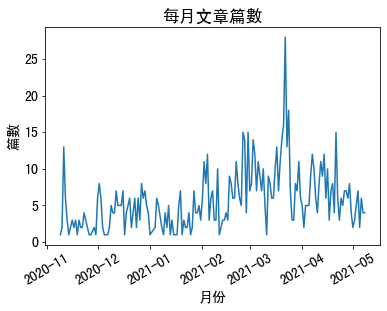

In [6]:
plt.plot(day_count['date'], day_count['count'])
plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30) # 旋轉x刻度避免重疊
plt.show()

## 斷詞引擎設定：使用 Jieba 當作斷詞系統

In [7]:
import jieba
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
jieba.set_dictionary('./data/dict.txt') 

# 自定義辭典
jieba.load_userdict('./data/user_dict.txt')


Building prefix dict from /Users/changfangyu/Desktop/NSYSU/碩班/110 社群媒體/week12-主題模型/data/dict.txt ...
Loading model from cache /var/folders/yw/v6fz89fx5pd827bs1070ywr00000gn/T/jieba.u6593d7d1399ca2097a7f2e6a79a9e750.cache
Loading model cost 0.386 seconds.
Prefix dict has been built successfully.


In [8]:
# 資料進行斷詞，為list的格式
data = metadata[['artUrl','sentence']]
token_df = data.assign(wordlist = data['sentence'].apply(jieba.lcut))

### 移除停用字（空格、標點符號、無意義字...）

In [9]:
# 匯入檔案形式
stopwords = []

#匯入檔案
with open(f'./data/stopwords.txt','r') as f:
    stopwords = f.read().splitlines() #移除換行符號\n

In [10]:
# 移除停用字的 function
def remove_stop(listt):
    result = [word for word in listt if len(word)>1] #字的長度要大於一
    result = list(filter(lambda x : x not in stopwords, result)) #只選沒有在停用字點裡的字
    return result

In [11]:
# list 刪掉 stopwords
token_df = token_df.assign( remove_stopwords = token_df['wordlist'].apply(remove_stop))
token_df.head(3)

,artUrl,sentence,wordlist,remove_stopwords
0,https://tw.appledaily.com/international/202103...,美國總統拜登11日在簽署1.9兆美元紓困後發表上任後首次的黃金時段演說，他表示會下令各州在5...,"[美國, 總統, 拜登, 11, 日, 在, 簽署, 1.9, 兆, 美元, 紓困, 後, ...","[美國, 總統, 拜登, 11, 簽署, 1.9, 美元, 紓困, 發表, 上任, 首次, ..."
1,https://udn.com/news/story/120940/5343188,國內3月22日開打AZ疫苗後，傳出北部某醫學中心一名40多歲護理師，接種AZ疫苗後出現急性過...,"[國內, 3, 月, 22, 日, 開打, AZ, 疫苗, 後, ，, 傳出, 北部, 某,...","[國內, 22, 開打, AZ, 疫苗, 傳出, 北部, 醫學, 中心, 一名, 40, 多..."
2,https://udn.com/news/story/120944/5055649,俄羅斯新聞社（RIA）今天引述聯邦消費者權益保護暨福利監督署的說法報導，俄羅斯計劃從今天起對...,"[俄羅斯, 新聞社, （, RIA, ）, 今天, 引述, 聯邦, 消費者, 權益, 保護,...","[俄羅斯, 新聞社, RIA, 今天, 引述, 聯邦, 消費者, 權益, 保護, 福利, 監..."


## 建立LDA模型

In [12]:
from gensim import corpora
token_data = token_df['remove_stopwords'].tolist()

In [13]:
# 創建語料(corpus)的詞語詞典，每個詞都被賦予一個索引（word_id，word_frequency）
id2word = corpora.Dictionary(token_data)

In [14]:
# 將詞典轉換文檔列表（語料）變成 Document Term Matrix
corpus = [id2word.doc2bow(text) for text in token_data]

In [15]:
# 語料庫(corpus)是（word_id，word_frequency）的對映。
id2word.doc2bow(['世界','衛生','疫苗'])

[(128, 1), (153, 1), (607, 1)]

## 利用 DTM 訓練 LDA 模型

In [16]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, # DTM
    id2word=id2word, # 字典
    num_topics=6, # 代表生成幾個主題數
    random_state=100, # 亂數
    iterations = 1000,
    passes=5, # 模型訓練次數
    # alpha='auto',
    # per_word_topics=True
)
# 15s

## 查看LDA模型中的主題關鍵字

In [17]:
# 每個主題重要的前十個關鍵字
topics = ldamodel.print_topics(num_words=10)
for topic in topics:

    # 原始
    # print(topic) 

    # 整理成方便閱讀
    # topic[0]：為主題編號
    termNumber = topic[0]
    print(topic[0], ':', sep='')

    # topic[1]：為主題字，split：遇到什麼字就分開
    listOfTerms = topic[1].split('+')
    for term in listOfTerms:
        # listItems[0]為機率 、 listItems[1]為詞彙
        listItems = term.split('*')
        print('  ', listItems[1], listItems[0], sep=' ')

0:
   "疫苗"  0.062
   "接種"   0.019
   "歐盟"   0.009
   "表示"   0.009
   "AZ"   0.008
   "英國"   0.008
   "新冠"   0.008
   "施打"   0.007
   "疫情"   0.006
   "數據"  0.006
1:
   "疫苗"  0.042
   "中國"   0.026
   "接種"   0.008
   "國家"   0.007
   "表示"   0.006
   "全球"   0.005
   "疫情"   0.005
   "報導"   0.005
   "生產"   0.004
   "新冠"  0.004
2:
   "疫苗"  0.012
   "接種"   0.007
   "民進黨"   0.004
   "委員會"   0.004
   "抗議"   0.004
   "調閱"   0.003
   "成立"   0.003
   "立委"   0.003
   "小組"   0.003
   "衛環"  0.003
3:
   "疫苗"  0.053
   "接種"   0.023
   "新冠"   0.010
   "病毒"   0.010
   "施打"   0.009
   "疫情"   0.008
   "表示"   0.007
   "數據"   0.006
   "肺炎"   0.006
   "全球"  0.006
4:
   "疫苗"  0.056
   "新冠"   0.010
   "台灣"   0.009
   "疫情"   0.009
   "表示"   0.009
   "接種"   0.007
   "試驗"   0.007
   "施打"   0.007
   "採購"   0.006
   "數據"  0.005
5:
   "疫苗"  0.035
   "接種"   0.027
   "醫院"   0.014
   "施打"   0.012
   "疫情"   0.011
   "人員"   0.010
   "中心"   0.010
   "新冠"   0.009
   "指揮"   0.009
   "AZ"  0.009


### 猜測可能主題
+ 主題一：全球疫情狀況
+ 主題二：中國疫情、疫苗
+ 主題三：疫苗相關討論

## LDA 模型指標
+ Pairwise Pointwise Mutual Information : 主題連貫性 (越大越好)
+ perplexity score : 複雜度（越小越好）

In [18]:
from gensim.models import CoherenceModel
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('PMI score: ', PMI_lda)

PMI score:  -0.5624657740845059


In [19]:
perplexity = ldamodel.log_perplexity(corpus)
# a measure of how good the model is. lower the better.
print('Perplexity Score: ', perplexity)

Perplexity Score:  -7.838951930149569


## 尋找最佳主題數
+ 透過建立多個主題數的模型，以perplexity為指標

In [20]:
topic_num_list = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 100,
        passes=5,
        iterations=1000 )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    
    result.append({"topic_num": topic_num, "perplexity": tmp_perplexity})
# 7分鐘跑完
# 改iteration(1000跟2000差不多)

,topic_num,perplexity
0,5,-7.852458
1,10,-7.878405
2,15,-7.910146
3,20,-7.956712
4,25,-7.989067
5,30,-8.023500
6,35,-8.056932
7,40,-8.084657
8,45,-8.114675
9,50,-8.152066


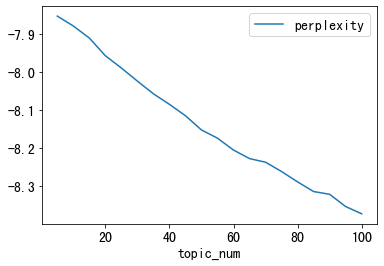

In [21]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

## 區間改小

In [22]:
topic_num_list = [2,4,6,8,10,12,14,16,18,20]
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 2021,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)

    result.append({"topic_num": topic_num, "perplexity": tmp_perplexity})
#3分鐘跑完

,topic_num,perplexity
0,2,-7.835628
1,4,-7.851544
2,6,-7.861231
3,8,-7.861353
4,10,-7.873210
5,12,-7.880510
6,14,-7.908693
7,16,-7.923333
8,18,-7.941218
9,20,-7.950550


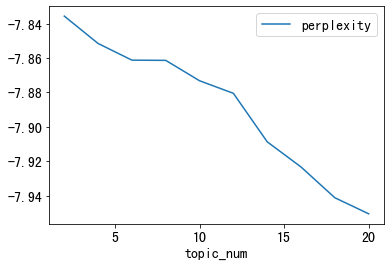

In [23]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

## LDAvis 視覺化呈現

In [24]:
import pyLDAvis.gensim_models
ldaVis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
pyLDAvis.save_html(ldaVis,'./lda_result/ldaVis.html')

/Users/changfangyu/opt/anaconda3/envs/fanny_nltk/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


# Document 主題分佈

In [25]:
# 取得每條新聞的主題分佈
topics_doc = ldamodel.get_document_topics(corpus)  

# 將結果列成list
doc_list = []

# topics_doc[i] 為第一個文章
for i in range(0,len(topics_doc)):

    # 都先假定第一個主題為最大的
    max_freq = topics_doc[i][0][1]
    max_topic = topics_doc[i][0][0]

    # 後面假如有比較大的就取代
    for j in topics_doc[i]:
        if(j[1] > max_freq):
            max_freq = j[1]
            max_topic = j[0]

    # print(max_topic)
    # print(max_freq)
    doc_list.append(max_topic)

In [26]:
# 將結果放進 DataFrame裏
metadata['topic'] = doc_list

In [27]:
# 將 artDate 轉換為 Python 日期時間
metadata.artDate = pd.to_datetime(metadata['artDate'])

In [28]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':metadata.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()
# date_topic.artDate.dt.to_period('M')：把日期按月份形式表示
date_topic = date_topic.groupby([date_topic.artDate.dt.to_period('M'),'topic']).sum().reset_index()


In [29]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5']
# 前面日期變period形式要把他變回timestamp形式 --> to_timestamp：以便於畫圖
date_df = date_df.set_index('artDate').to_timestamp()
date_df

,topic0,topic1,topic2,topic3,topic4,topic5
artDate,,,,,,
2020-11-01,7.0,1.0,0.0,17.0,31.0,0.0
2020-12-01,17.0,2.0,1.0,74.0,36.0,2.0
2021-01-01,14.0,4.0,0.0,49.0,17.0,0.0
2021-02-01,34.0,6.0,3.0,50.0,92.0,7.0
2021-03-01,60.0,18.0,7.0,77.0,77.0,56.0
2021-04-01,38.0,10.0,0.0,56.0,41.0,63.0
2021-05-01,2.0,5.0,3.0,7.0,8.0,8.0


## 可以看到在不同時間點，特定主題談論的篇幅多寡

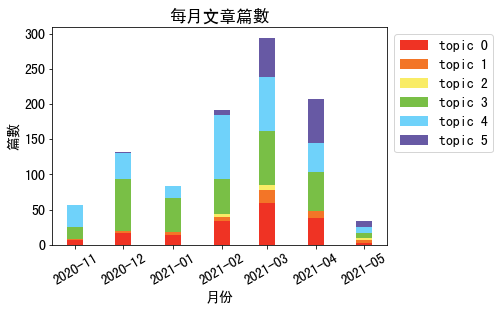

In [30]:
plt.bar(date_df.index, date_df.topic0 ,color="#EF3324",label="topic 0", width=10) #主題一
plt.bar(date_df.index, date_df.topic1,color="#F37527" ,bottom=date_df.topic0 ,label="topic 1" , width=10) #主題二
plt.bar(date_df.index, date_df.topic2,color="#F9EC66", bottom=date_df.topic1 + date_df.topic0, label="topic 2", width=10) #主題三
plt.bar(date_df.index, date_df.topic3, color="#79BF46", bottom=date_df.topic1 + date_df.topic0 + date_df.topic2, label="topic 3", width=10) #主題四
plt.bar(date_df.index, date_df.topic4, color="#6FD2FA", bottom=date_df.topic1 + date_df.topic0 + date_df.topic2 + date_df.topic3, label="topic 4", width=10) #主題五
plt.bar(date_df.index, date_df.topic5, color="#6759A4", bottom=date_df.topic1 + date_df.topic0 + date_df.topic2 + date_df.topic3 + date_df.topic4, label="topic 5", width=10) #主題六

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

## 以比例來看

In [31]:
ratio_df = date_df.copy()
ratio_df['sum'] = ratio_df.topic0 + ratio_df.topic1 + ratio_df.topic2 + ratio_df.topic3 + ratio_df.topic4 + ratio_df.topic5
ratio_df['topic0'] = ratio_df['topic0'] / ratio_df['sum']
ratio_df['topic1'] = ratio_df['topic1'] / ratio_df['sum']
ratio_df['topic2'] = ratio_df['topic2'] / ratio_df['sum']
ratio_df['topic3'] = ratio_df['topic3'] / ratio_df['sum']
ratio_df['topic4'] = ratio_df['topic4'] / ratio_df['sum']
ratio_df['topic5'] = ratio_df['topic5'] / ratio_df['sum']

ratio_df

,topic0,topic1,topic2,topic3,topic4,topic5,sum
artDate,,,,,,,
2020-11-01,0.125000,0.017857,0.000000,0.303571,0.553571,0.000000,56.0
2020-12-01,0.128788,0.015152,0.007576,0.560606,0.272727,0.015152,132.0
2021-01-01,0.166667,0.047619,0.000000,0.583333,0.202381,0.000000,84.0
2021-02-01,0.177083,0.031250,0.015625,0.260417,0.479167,0.036458,192.0
2021-03-01,0.203390,0.061017,0.023729,0.261017,0.261017,0.189831,295.0
2021-04-01,0.182692,0.048077,0.000000,0.269231,0.197115,0.302885,208.0
2021-05-01,0.060606,0.151515,0.090909,0.212121,0.242424,0.242424,33.0


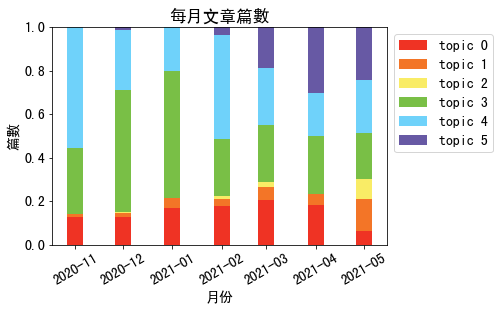

In [32]:
plt.bar(ratio_df.index, ratio_df.topic0 ,color="#EF3324",label="topic 0", width=10) #主題一
plt.bar(ratio_df.index, ratio_df.topic1,color="#F37527" ,bottom=ratio_df.topic0 ,label="topic 1" , width=10) #主題二
plt.bar(ratio_df.index, ratio_df.topic2,color="#F9EC66", bottom=ratio_df.topic1 + ratio_df.topic0, label="topic 2", width=10) #主題三
plt.bar(ratio_df.index, ratio_df.topic3, color="#79BF46", bottom=ratio_df.topic1 + ratio_df.topic0 + ratio_df.topic2, label="topic 3", width=10) #主題四
plt.bar(ratio_df.index, ratio_df.topic4, color="#6FD2FA", bottom=ratio_df.topic1 + ratio_df.topic0 + ratio_df.topic2 + ratio_df.topic3, label="topic 4", width=10) #主題五
plt.bar(ratio_df.index, ratio_df.topic5, color="#6759A4", bottom=ratio_df.topic1 + ratio_df.topic0 + ratio_df.topic2 + ratio_df.topic3 + ratio_df.topic4, label="topic 5", width=10) #主題六

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

##  隨機看一下不同主題大概都在談論什麼

In [33]:
## 主題一
metadata[metadata['topic'] == 0].sample(n=5)

,artTitle,artDate,artTime,artUrl,sentence,topic
400,2人打2劑科興疫苗不治 香港累計23死,2021-04-25,14:08:00,https://udn.com/news/story/120944/5412071,再多兩名曾接種兩劑新冠疫苗的人離世，涉及1名75歲男子及1名58歲女子，兩人同樣有高血壓等長...,0
56,歐盟商討「疫苗護照」意見分歧 德法：恐造成歧視,2021-02-26,15:25:00,https://udn.com/news/story/120944/5279388,隨著各國陸續開展接種新冠疫苗計畫，歐盟25日開會討論是否在區內推出「疫苗護照」，以便重啟旅遊...,0
690,陳建仁：無須擔心AZ疫苗施打 接種前諮詢醫師,2021-04-24,14:04:00,https://udn.com/news/story/120940/5410957,前副總統陳建仁今天到台南參加「全台首學課程博覽會」，他以「立足台灣放眼天下」為題做專題講演。...,0
621,【新冠肺炎】「有人能幫我搞到輝瑞疫苗」《環時》總編洩密刪文,2021-04-19,13:52:25,https://tw.appledaily.com/international/202104...,中國製疫苗傳出不但有人接種後確診，在香港還造成14死，中國疫苗安全和效果都引發質疑，中國官媒...,0
667,數據不足！ 歐盟：可能僅授權牛津AZ疫苗給年輕人接種,2021-01-27,10:17:00,https://udn.com/news/story/120944/5208572,歐盟藥品管理局（EMA）執行主任庫克（Emer Cooke）暗示，牛津/AZ（Oxford/...,0


In [34]:
## 主題二
metadata[metadata['topic'] == 1].sample(n=5)

,artTitle,artDate,artTime,artUrl,sentence,topic
886,民調：英美等國民眾對疫苗接受度顯著升高,2021-03-01,12:03:00,https://udn.com/news/story/120944/5285217,一項針對英國、美國等6個工業化國家執行的民調今天公布結果，顯示民眾接種2019冠狀病毒疾病（...,1
740,鐘南山：輝瑞疫苗能阻90%感染 大陸疫苗也差不多,2020-11-16,14:02:00,https://udn.com/news/story/120944/5018933,2020官洲國際生物論壇今起在廣州國際生物島舉行，論壇主題為科技創新引領健康未來，中國工程院...,1
683,大陸將與阿根廷合作 生產大陸國藥集團新冠疫苗,2021-05-04,11:50:00,https://udn.com/news/story/120944/5432252,據中國大陸駐阿根廷大使館當地時間5月3日消息，中國駐阿根廷大使鄒肖力當天與阿根廷衛生部長維佐...,1
310,接種中國武漢肺炎疫苗仍確診 聖地牙哥大主教染疫住院,2021-04-11,18:00:34,https://tw.appledaily.com/international/202104...,智利羅馬天主教會昨天（10日）表示，現年76歲的智利聖地牙哥大主教艾歐斯（Celestino...,1
773,巴西經濟部長「中國發明病毒，疫苗不如美國有效」 中國不爽了,2021-04-29,16:07:55,https://tw.appledaily.com/international/202104...,巴西衛生部周三（4/28）通報，新增確診病例7萬9726例、3163死，累計確診病例1452...,1


In [35]:
## 主題三
metadata[metadata['topic'] == 2].sample(n=5)

,artTitle,artDate,artTime,artUrl,sentence,topic
771,成立疫苗調閱小組 朝野協商照案通過,2021-03-24,12:50:00,https://udn.com/news/story/6656/5340102,立法院衛環委員會上周通過成立「疫苗採購調閱小組」，周一民進黨立委以程序瑕疵表決刪除該案，國民...,2
575,歐洲多國爆「反防疫示威」 高呼解禁、拒打疫苗,2021-03-21,14:19:00,https://udn.com/news/story/120944/5333060,歐美各國展開疫苗接種多時，但是疫情仍未完全消退，民眾卻已經厭倦遵守防疫限制措施。歐洲多個國家...,2
716,「赴美旅遊+打嬌生新冠疫苗」 泰國豪華團2人即可成行,2021-05-04,20:52:41,https://tw.appledaily.com/international/202105...,新冠肺炎目前仍在泰國肆虐，本（5）月4日全泰確診1763例，死亡人數也持續攀升，近日網路傳出...,2
463,港府設保障基金 打新冠疫苗傷亡最高賠償千萬,2021-02-18,08:49:00,https://udn.com/news/story/120944/5257422,香港預計3月初開始施打新冠疫苗，據香港文匯報報導，為提升市民的接種意願，港府將成立港幣10億...,2
802,新冠疫苗貨櫃藏幸運號碼 她對號中了1000萬頭獎｜東森新聞,2021-03-03,00:00:00,https://news.ebc.net.tw/news/article/251551,眼睛撇了一下貨櫃號碼，竟就此成為千萬富婆？日前泰國一名女子看到裝疫苗的貨櫃有編號，在記得其中...,2
